# importing libraries

In [1]:
import rasterio
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.utils import resample
from matplotlib.colors import Normalize
from matplotlib import cm

# loading tiff

In [ ]:
# Read the merged raster file and convert bands to a DataFrame
with rasterio.open("../data/all_data_merged.tif") as src:
    bands = []
    for b in range(1, src.count + 1):
        bands.append(src.read(b).ravel())
    df = pd.DataFrame({f"band_{i+1}": data for i, data in enumerate(bands)})

# Replace placeholder values (1e9) with NaN
df = df.mask(df == 1e9, float("nan"))

# Drop rows with any NaN values and reset the index
df = df.dropna().reset_index(drop=True)

# Save the cleaned DataFrame to a CSV file
df.to_csv("../data/all_data_merged_wo_nan.csv", index=False)


# building RF model

Accuracy: 0.7945205479452054
F1: 0.8351648351648352


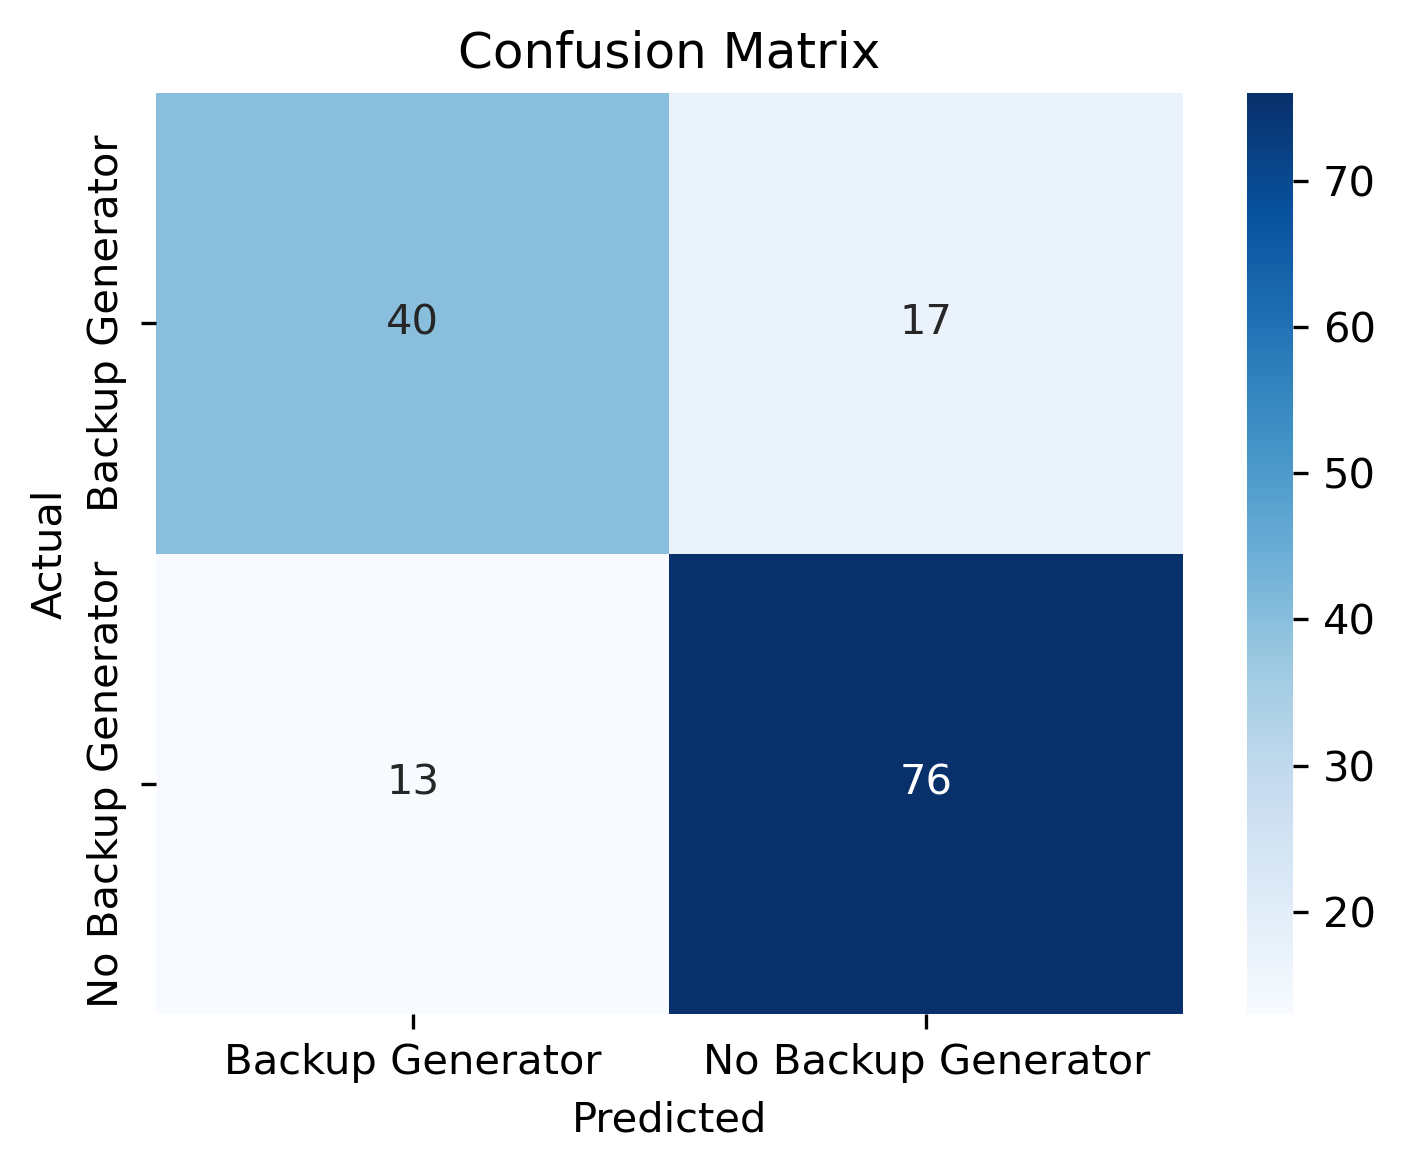

In [3]:
# Prepare data for modeling
y_class = (df["band_8"] == 1.0).astype(int)
X = df.drop(columns=["band_8"])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_class, test_size=0.2, random_state=42
)

# Train a Random Forest Classifier
clf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
)
clf.fit(X_train, y_train)

# Evaluate the model
proba = clf.predict_proba(X_test)[:, 1]
pred  = clf.predict(X_test)

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, pred))
print("F1:", f1_score(y_test, pred))

# Plot confusion matrix
corr_mat = confusion_matrix(y_test, pred)
corr_mat = pd.DataFrame(
    corr_mat,
    index=["Backup Generator", "No Backup Generator"],
    columns=["Backup Generator", "No Backup Generator"]
)
fig, ax = plt.subplots(figsize=(5, 4), dpi=300)
sns.heatmap(corr_mat, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.tight_layout()
plt.show()

# determining variable importance

In [4]:
# Variable Importance via Permutation Importance with Bootstrapping
n_replicates = 100
vip_counts = pd.Series(0, index=X.columns, dtype=int)
importance_records = []

# Bootstrap replicates for permutation importance
for i in range(n_replicates):
    # Bootstrap resampling
    seed = 42 + i
    X_boot, y_boot = resample(X_train, y_train, replace=True, random_state=seed)
    rf_rep = RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        random_state=seed,
        n_jobs=-1,
    )
    rf_rep.fit(X_boot, y_boot)

    # Compute permutation importance
    perm = permutation_importance(
        rf_rep,
        X_test,
        y_test,
        n_repeats=10,
        random_state=seed,
        n_jobs=-1,
        scoring='f1',
    )
    importance_records.append(perm.importances_mean)
    vip_counts += (perm.importances_mean > 0).astype(int)

# Aggregate results
importance_matrix = pd.DataFrame(importance_records, columns=X.columns)

# Summarize Variable Importance
vip_summary = pd.DataFrame(
    {
        "mean_permutation_importance": importance_matrix.mean(),
        "std_permutation_importance": importance_matrix.std(),
        "variable_inclusion_proportion": vip_counts / n_replicates,
    }
).sort_values("variable_inclusion_proportion", ascending=False)

# Calculate correlation with target variable
corr_matrix = X.assign(target=y_class).corr()
vip_summary["corr_with_target"] = corr_matrix.loc[X.columns, "target"]

# visualizing results

/var/folders/zf/m0p4r__d7gb0cphf85xj8z180000gn/T/ipykernel_14144/2927561983.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


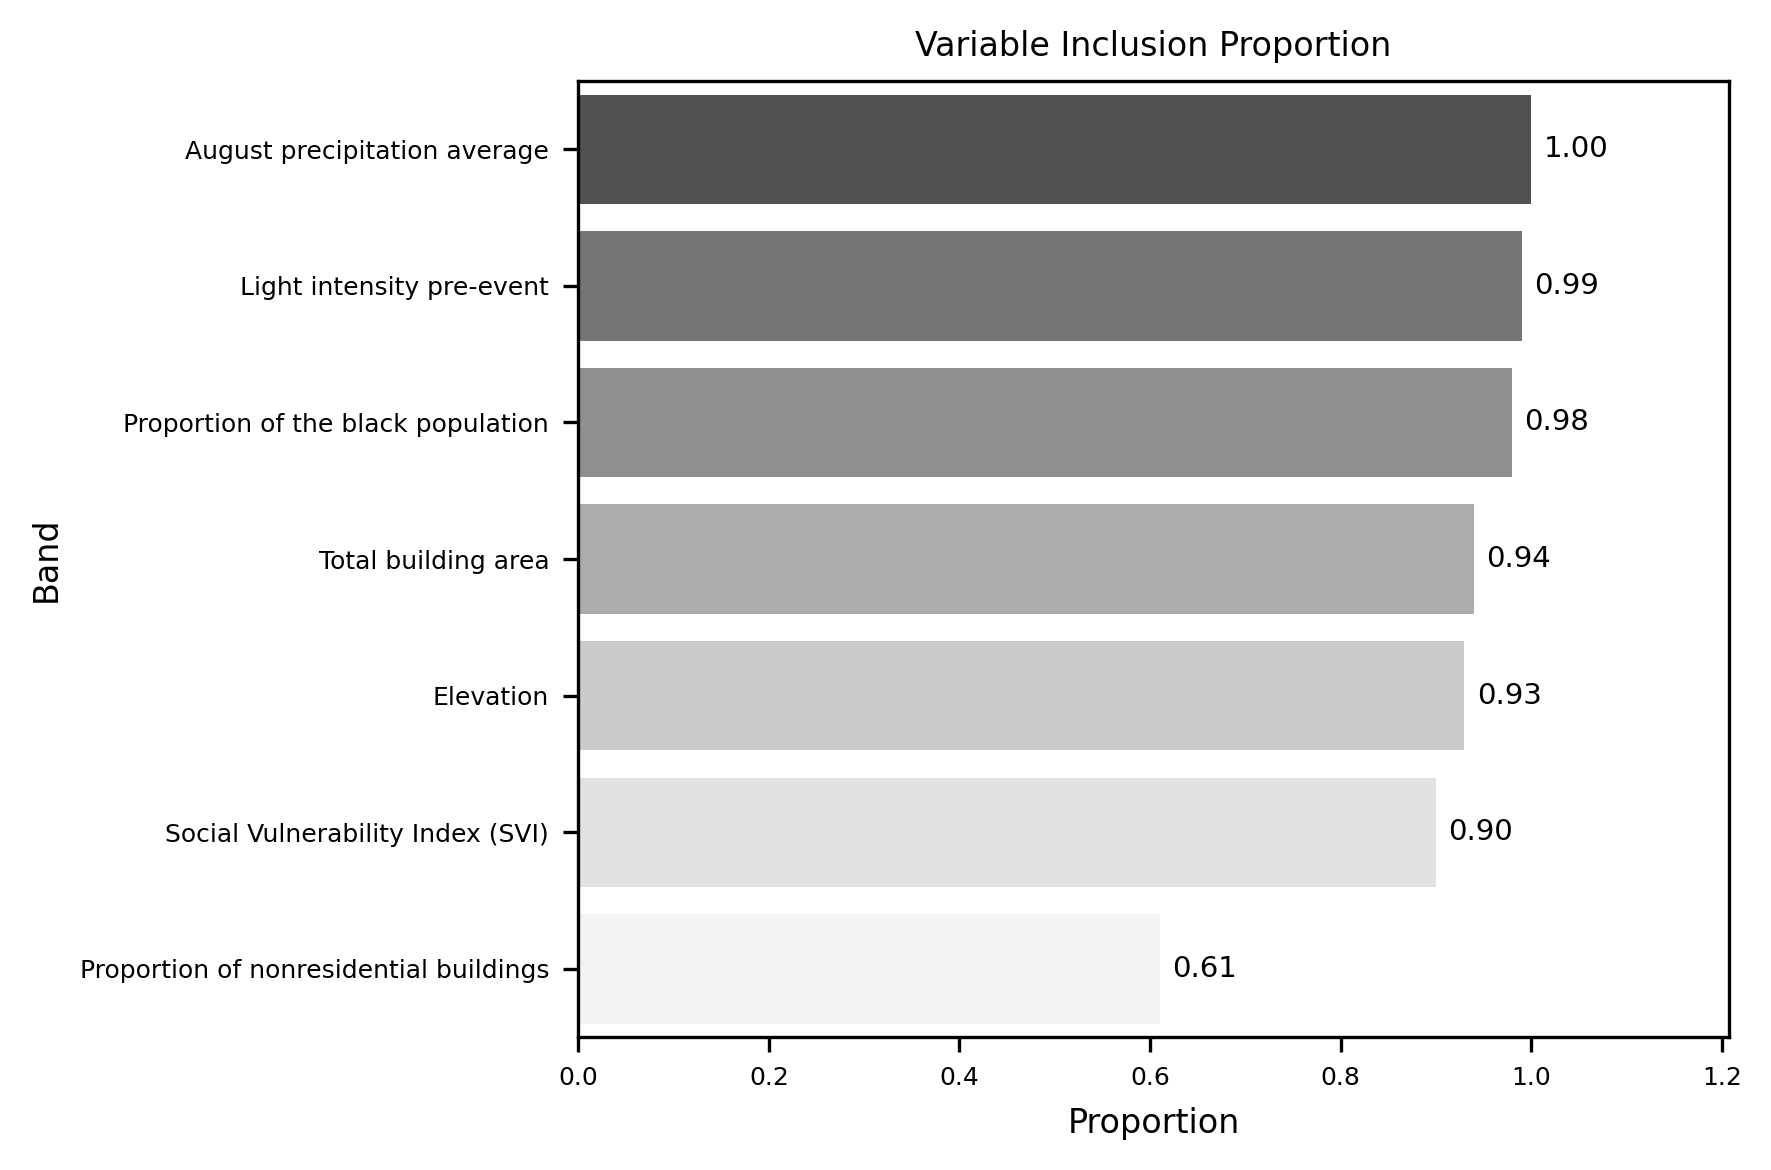

/var/folders/zf/m0p4r__d7gb0cphf85xj8z180000gn/T/ipykernel_14144/2927561983.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


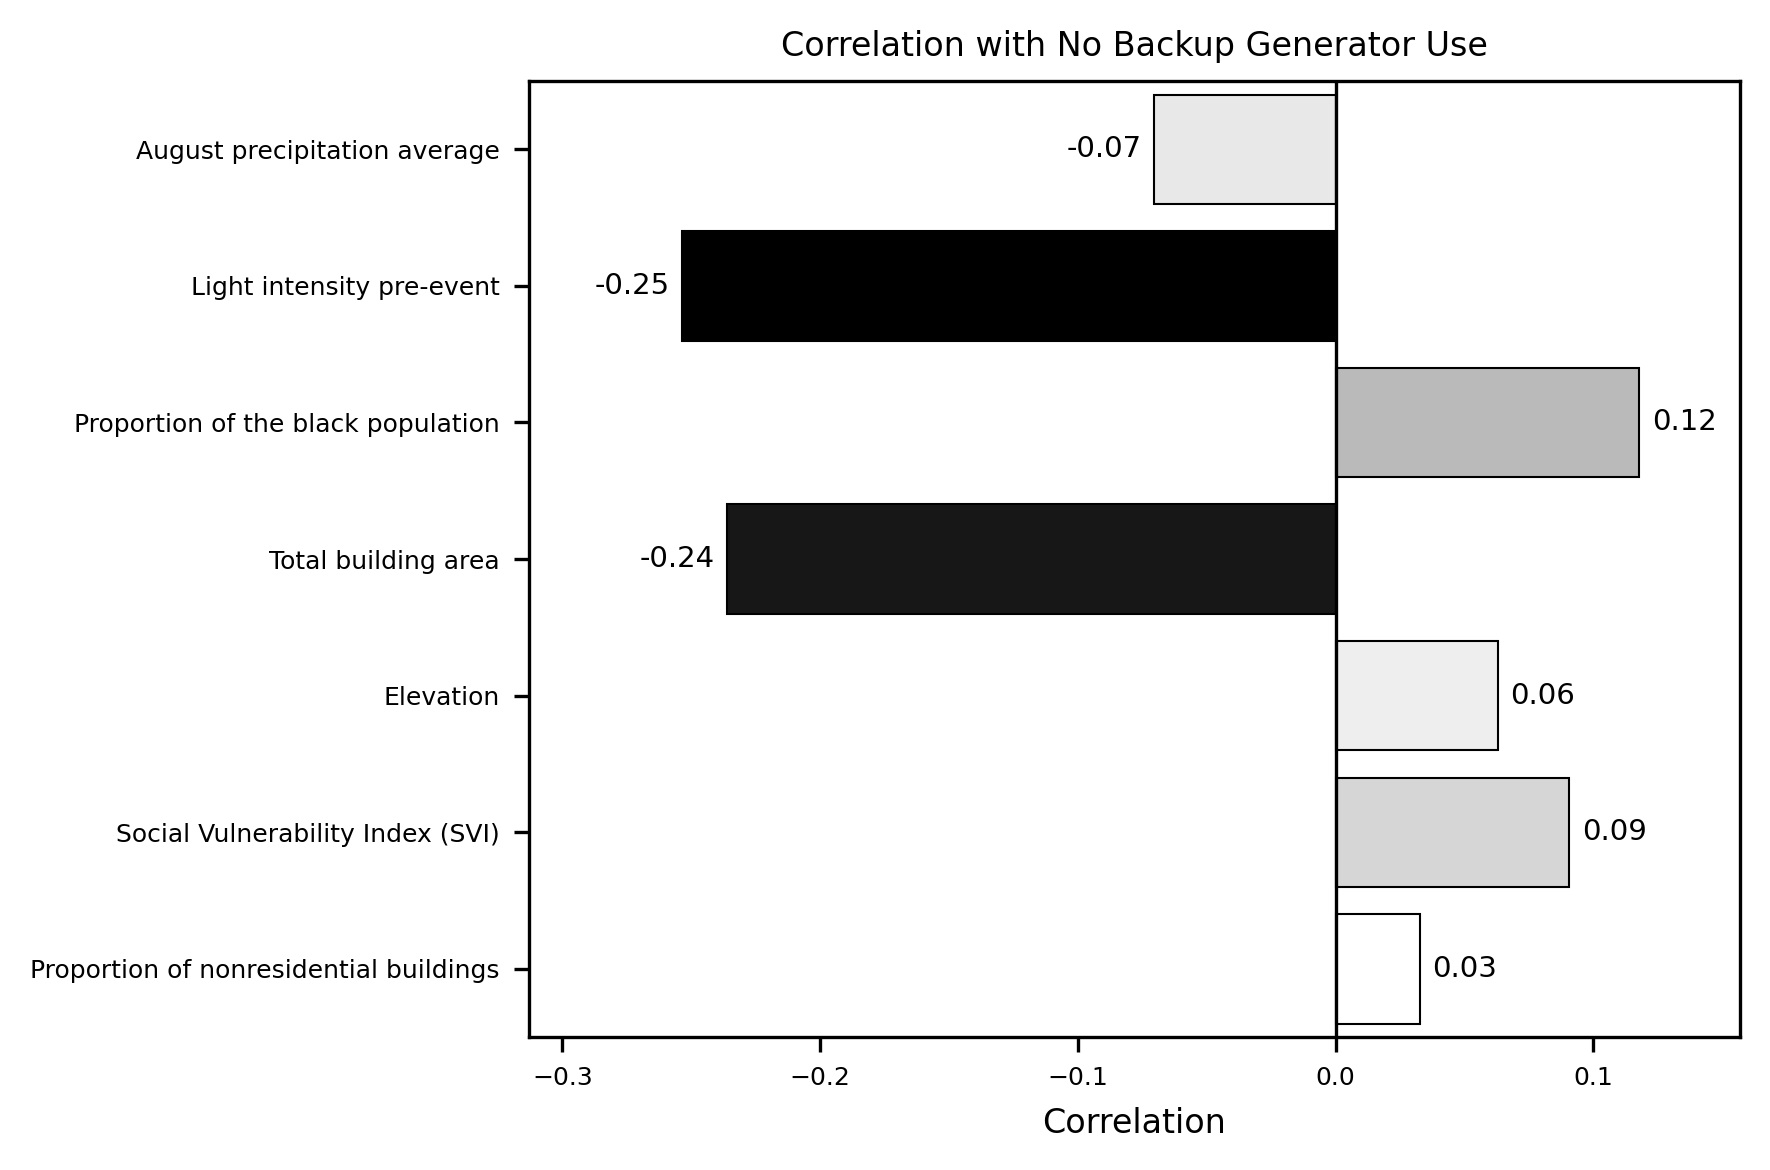

In [5]:
# Display Variable Importance Summary with descriptive band names
band_name_map = {
    "band_1": "Proportion of nonresidential buildings",
    "band_2": "Total building area",
    "band_3": "Social Vulnerability Index (SVI)",
    "band_4": "Proportion of the black population",
    "band_5": "Light intensity pre-event",
    "band_6": "Elevation",
    "band_7": "August precipitation average",
}

# Prepare data for plotting
summary_plot = (
    vip_summary.reset_index()
    .rename(columns={"index": "band"})
    .assign(band=lambda df_: df_["band"].map(band_name_map))
)

# Function to expand x-axis limits
def expand_xlim(ax, expand=1.15):
    left, right = ax.get_xlim()
    left = left * expand if left < 0 else left
    right = right * expand
    ax.set_xlim(left, right)

# -----------------------------
# 1) Variable Inclusion Proportion (separate figure)
# -----------------------------

# Plot Variable Inclusion Proportion
fig1, ax1 = plt.subplots(figsize=(6, 4), dpi=300)

# Plotting
sns.barplot(
    data=summary_plot,
    x="variable_inclusion_proportion",
    y="band",
    ax=ax1,
    palette="Grays_r",
    alpha=0.8
)

# Customize plot
ax1.set_title("Variable Inclusion Proportion", fontsize=8)
ax1.set_xlabel("Proportion", fontsize=8)
ax1.set_ylabel("Band", fontsize=8)

# Add bar labels
for container in ax1.containers:
    ax1.bar_label(container, fmt="%.2f", padding=3, fontsize=7)

# Finalize plot
ax1.tick_params(axis="y", labelsize=6)
ax1.tick_params(axis="x", labelsize=6)
expand_xlim(ax1)

# Show plot
plt.tight_layout()
plt.show()

# -----------------------------
# 2) Correlation with Target (separate figure)
# -----------------------------

# Color mapping based on absolute correlation values
corr_abs = summary_plot["corr_with_target"].abs()
norm = Normalize(vmin=corr_abs.min(), vmax=corr_abs.max())
cmap = cm.Grays
corr_colors = [cmap(norm(v)) for v in corr_abs]

# Plot Correlation with Target
fig2, ax2 = plt.subplots(figsize=(6, 4), dpi=300)

# Plotting
sns.barplot(
    data=summary_plot,
    x="corr_with_target",
    y="band",
    ax=ax2,
    palette=corr_colors,
    edgecolor="black",
    linewidth=0.5,
)

# Customize plot
ax2.axvline(0, color="black", linewidth=0.8)
ax2.set_title("Correlation with No Backup Generator Use", fontsize=8)
ax2.set_xlabel("Correlation", fontsize=8)
ax2.set_ylabel("") 

# Add bar labels
for container in ax2.containers:
    ax2.bar_label(container, fmt="%.2f", padding=3, fontsize=7)

# Finalize plot
ax2.tick_params(axis="y", labelsize=6)
ax2.tick_params(axis="x", labelsize=6)
expand_xlim(ax2)

# Show plot
plt.tight_layout()
plt.show()